In [2]:
# data clean
# PCA for feature selection top 20
# xgb regressor - separate model for every strike
# trained on training and testing data non nans
# extrapolation for unseen strikes

# This Python 3 environment comes with many helful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt

In [30]:
train_df = pd.read_parquet(f'train_data.parquet')
# train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
print(len(train_df))
# print(train_df.isna().sum(axis=1))
# print(train_df['X0'].head(10))
# train_df['underlying'].describe()
train_df = train_df.drop(columns=['timestamp', 'expiry'])
print(train_df.columns)

178340
Index(['underlying', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700',
       'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'put_iv_22500',
       'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'X0', 'X1', 'X2', 'X3',

In [ ]:
# Get columns that are IV-related (call_iv or put_iv)
iv_cols = [col for col in train_df.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

# Create a boolean mask for valid rows (all IV values between 0 and 100 inclusive)
valid_rows_mask = ~((train_df[iv_cols] < 0) | (train_df[iv_cols] > 100)).any(axis=1)
# valid_rows_mask = ~(train_df[iv_cols] < 0).any(axis=1)

# Apply mask to filter the DataFrame
clean_df = train_df[valid_rows_mask].copy()

print(f"Removed {len(train_df) - len(clean_df)} invalid rows.")
train_df = clean_df
print(len(train_df))

Removed 299 invalid rows.
178041


In [3]:
test_df = pd.read_parquet(f'test_data.parquet')
# train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
print(len(test_df))
test_df = test_df.drop(columns=['timestamp'])
print(test_df.columns)
# print(test_df.isna().sum(axis=1))
print(test_df.head(10))
# test_df['underlying'].describe()

12065
Index(['underlying', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200',
       'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600',
       'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000',
       'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400',
       'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800',
       'call_iv_25900', 'call_iv_26000', 'call_iv_26100', 'call_iv_26200',
       'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'put_iv_23000',
       'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400',
       'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800',
       'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200',
       'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600',
       'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000',
       'put_iv_25100', 'put_iv_25200', 'put_iv_25300', 'put_iv_25400',
       'put_iv_25500', 'X0', 'X1', 'X2', 'X3', 

# PCA

In [33]:
from sklearn.preprocessing import StandardScaler

X = train_df.drop(columns=iv_cols)
# print(X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

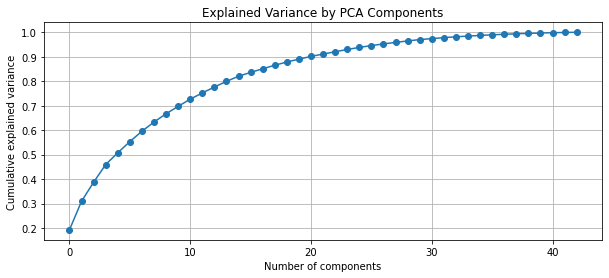

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.title("Explained Variance by PCA Components")
plt.show()


In [36]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Number of components explaining 95% variance: 27


In [37]:
loading_matrix = pca.components_.T  # shape: (n_features, n_components)
feature_importance = np.abs(loading_matrix[:, :n_components]).sum(axis=1)
feature_scores = pd.Series(feature_importance, index=X.columns).sort_values(ascending=False)

# Top 20 most influential original features
top_features = feature_scores.head(20)
top_features = top_features.index.tolist()

# print(top_features)

In [38]:
# train_df = train_df[:1000]
# test_df = test_df[:1000]

In [39]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# Assuming train_df and test_df are already defined and loaded

# Extract base features (excluding IV columns)
# feature_cols = [col for col in train_df.columns if col.startswith("X")]

# Identify IV columns common to both datasets
common_iv_cols = [col for col in train_df.columns if col in test_df.columns and ('call_iv_' in col or 'put_iv_' in col)]

# Dictionary to store predictions
iv_predictions = {}

for iv_col in common_iv_cols:
    # Extract strike price from column name
    strike = int(iv_col.split('_')[-1])
    is_call = iv_col.startswith("call")

    # Compute moneyness feature for both train and test
    train_mny = train_df["underlying"] / strike if is_call else strike / train_df["underlying"]
    test_mny = test_df["underlying"] / strike if is_call else strike / test_df["underlying"]

    # Add moneyness to features
    X_train = train_df[top_features].copy()
    X_train["moneyness"] = train_mny
    y_train = train_df[iv_col]

    # # Drop NaNs from training target
    # not_nan_train = ~y_train.isna()
    # X_train = X_train[not_nan_train]
    # y_train = y_train[not_nan_train]
    # print(sum(y_train.isna()))
    # exit

    # Train XGBoost model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1)
    model.fit(X_train, y_train)

    # Fine-tune on test data where target is not NaN
    if iv_col in test_df.columns:
        y_test_partial = test_df[iv_col]
        not_nan_test = ~y_test_partial.isna()

        X_test_partial = test_df.loc[not_nan_test, top_features].copy()
        X_test_partial["moneyness"] = test_df.loc[not_nan_test, "underlying"] / strike if is_call else strike / test_df.loc[not_nan_test, "underlying"]

        if not X_test_partial.empty:
            model.fit(X_test_partial, y_test_partial[not_nan_test], xgb_model=model)

    # Predict NaNs in test data
    is_nan = test_df[iv_col].isna()
    if is_nan.any():
        X_test_nan = test_df.loc[is_nan, top_features].copy()
        X_test_nan["moneyness"] = test_df.loc[is_nan, "underlying"] / strike if is_call else strike / test_df.loc[is_nan, "underlying"]
        preds = model.predict(X_test_nan)
        iv_predictions[iv_col] = (is_nan[is_nan].index, preds)
    
    print(f'prediction done on {iv_col}')

# Apply predictions back to test_df
for iv_col, (indices, preds) in iv_predictions.items():
    test_df.loc[indices, iv_col] = preds

print("Predictions done for:", list(iv_predictions.keys()))


prediction done on call_iv_24000
prediction done on call_iv_24100
prediction done on call_iv_24200
prediction done on call_iv_24300
prediction done on call_iv_24400
prediction done on call_iv_24500
prediction done on call_iv_24600
prediction done on call_iv_24700
prediction done on call_iv_24800
prediction done on call_iv_24900
prediction done on call_iv_25000
prediction done on call_iv_25100
prediction done on call_iv_25200
prediction done on call_iv_25300
prediction done on call_iv_25400
prediction done on call_iv_25500
prediction done on call_iv_25600
prediction done on call_iv_25700
prediction done on call_iv_25800
prediction done on call_iv_25900
prediction done on call_iv_26000
prediction done on put_iv_23000
prediction done on put_iv_23100
prediction done on put_iv_23200
prediction done on put_iv_23300
prediction done on put_iv_23400
prediction done on put_iv_23500
prediction done on put_iv_23600
prediction done on put_iv_23700
prediction done on put_iv_23800
prediction done on 

In [40]:
iv_cols = common_iv_cols

# 0 clipping
# test_df[iv_cols] = test_df[iv_cols].clip(lower=0)

In [41]:
iv_cols  = [col for col in test_df.columns if 'iv_' in col]
test_df[iv_cols].describe()

,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,call_iv_24900,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
count,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,...,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,4728.000000,4908.000000,4893.000000,4802.000000,4754.000000
mean,0.256532,0.246912,0.236372,0.226260,0.216521,0.208372,0.201176,0.194971,0.190691,0.189991,...,0.201240,0.195029,0.191242,0.190962,0.194038,0.198288,0.203936,0.208550,0.214189,0.221703
std,0.019092,0.017104,0.016845,0.016521,0.016777,0.017542,0.017959,0.018811,0.020911,0.023105,...,0.018101,0.018547,0.018602,0.020277,0.023403,0.028361,0.030016,0.031538,0.033077,0.035652
min,0.202137,0.194093,0.188013,0.173040,0.167824,0.138618,0.129156,0.025792,-0.076970,-0.142927,...,0.139859,0.143569,0.119007,0.123577,0.078504,0.167357,0.169678,0.171191,0.174086,0.176931
25%,0.242424,0.235996,0.225851,0.216266,0.206649,0.198262,0.190660,0.184104,0.179503,0.176620,...,0.190619,0.183683,0.179324,0.176505,0.175962,0.176190,0.178477,0.179466,0.181594,0.184401
50%,0.254190,0.244625,0.233916,0.223259,0.212708,0.204475,0.197033,0.190810,0.186459,0.183253,...,0.197095,0.190465,0.186120,0.183474,0.185362,0.182603,0.189237,0.194294,0.201514,0.209297
75%,0.267987,0.256711,0.246158,0.236671,0.227454,0.219496,0.212236,0.206053,0.202100,0.203838,...,0.212049,0.205488,0.202339,0.205219,0.212013,0.228495,0.234748,0.239611,0.246903,0.256159
max,0.365187,0.353372,0.323807,0.280493,0.267558,0.267430,0.269148,0.290301,0.276947,0.316249,...,0.282185,0.294215,0.320554,0.324932,0.326560,0.258352,0.263817,0.273556,0.316621,0.293659


In [42]:
from scipy.interpolate import interp1d

# --- Extrapolation function with numeric safety ---
def extrapolate_iv_curve(row, strike_cols, target_strike):
    strikes = [int(col.split("_")[-1]) for col in strike_cols]
    try:
        ivs = row[strike_cols].astype(float).values
    except Exception:
        return np.nan

    valid = ~np.isnan(ivs)
    if valid.sum() < 4:
        return np.nan

    strikes_valid = np.array(strikes)[valid]
    ivs_valid = ivs[valid]

    try:
        interpolator = interp1d(strikes_valid, ivs_valid, kind='linear', fill_value='extrapolate')
        return interpolator(target_strike)
    except Exception:
        return np.nan

# --- Get strike IV columns ---
train_iv_cols = [col for col in train_df.columns if 'iv_' in col]
test_iv_cols = [col for col in test_df.columns if 'iv_' in col]

# --- Missing in train, present in test (need to extrapolate) ---
extrapolate_targets = [col for col in test_iv_cols if col not in train_iv_cols]

# --- Separate IV columns ---
call_cols = [col for col in test_iv_cols if col.startswith('call_iv_')]
put_cols  = [col for col in test_iv_cols if col.startswith('put_iv_')]

# --- Separate targets ---
call_targets = [col for col in extrapolate_targets if col.startswith('call_iv_')]
put_targets  = [col for col in extrapolate_targets if col.startswith('put_iv_')]

# --- Call extrapolation ---
for target_col in call_targets:
    try:
        target_strike = int(target_col.split("_")[-1])
    except ValueError:
        continue

    print(f"Extrapolating CALL {target_col}...")
    test_df[target_col] = test_df.apply(
        lambda row: extrapolate_iv_curve(row, call_cols, target_strike)
        if pd.isna(row[target_col]) else row[target_col],
        axis=1
    )
    # call_cols.append(target_col)

# --- Put extrapolation ---
for target_col in put_targets:
    try:
        target_strike = int(target_col.split("_")[-1])
    except ValueError:
        continue

    print(f"Extrapolating PUT {target_col}...")
    test_df[target_col] = test_df.apply(
        lambda row: extrapolate_iv_curve(row, put_cols, target_strike)
        if pd.isna(row[target_col]) else row[target_col],
        axis=1
    )
    # put_cols.append(target_col)


Extrapolating CALL call_iv_26100...
Extrapolating CALL call_iv_26200...
Extrapolating CALL call_iv_26300...
Extrapolating CALL call_iv_26400...
Extrapolating CALL call_iv_26500...
Extrapolating PUT put_iv_25100...
Extrapolating PUT put_iv_25200...
Extrapolating PUT put_iv_25300...
Extrapolating PUT put_iv_25400...
Extrapolating PUT put_iv_25500...


In [ ]:
iv_cols  = [col for col in test_df.columns if 'iv_' in col]

In [44]:
# Create a copy of the IV columns
iv_df = test_df[iv_cols].copy()

# Add 0-indexed timestamp column
iv_df.insert(0, 'timestamp', range(len(iv_df)))

# Save to CSV
iv_df.to_csv("iv_predictions.csv", index=False)


In [45]:
import pandas as pd

df = pd.read_csv('iv_predictions.csv')  
df.describe()

# df = pd.read_parquet(f'test_data.parquet')
# put_calls  = [col for col in df.columns if 'put_' in col]
# df[put_calls].describe()


,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
count,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,...,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000,12065.000000
mean,6032.000000,0.256532,0.246912,0.236372,0.226260,0.216521,0.208372,0.201176,0.194971,0.190691,...,0.201240,0.195029,0.191242,0.190962,0.194038,0.198537,0.203354,0.208255,0.213417,0.218807
std,3483.009833,0.019092,0.017104,0.016845,0.016521,0.016777,0.017542,0.017959,0.018811,0.020911,...,0.018101,0.018547,0.018602,0.020277,0.023403,0.027407,0.032256,0.037723,0.043758,0.050356
min,0.000000,0.202137,0.194093,0.188013,0.173040,0.167824,0.138618,0.129156,0.025792,-0.076970,...,0.139859,0.143569,0.119007,0.123577,0.078504,0.057798,-0.003061,-0.079014,-0.154968,-0.230922
25%,3016.000000,0.242424,0.235996,0.225851,0.216266,0.206649,0.198262,0.190660,0.184104,0.179503,...,0.190619,0.183683,0.179324,0.176505,0.175962,0.177070,0.178469,0.179574,0.181179,0.182995
50%,6032.000000,0.254190,0.244625,0.233916,0.223259,0.212708,0.204475,0.197033,0.190810,0.186459,...,0.197095,0.190465,0.186120,0.183474,0.185362,0.186086,0.190362,0.194788,0.201115,0.207898
75%,9048.000000,0.267987,0.256711,0.246158,0.236671,0.227454,0.219496,0.212236,0.206053,0.202100,...,0.212049,0.205488,0.202339,0.205219,0.212013,0.224885,0.233288,0.240415,0.248430,0.255923
max,12064.000000,0.365187,0.353372,0.323807,0.280493,0.267558,0.267430,0.269148,0.290301,0.276947,...,0.282185,0.294215,0.320554,0.324932,0.326560,0.388339,0.464589,0.540840,0.662433,0.802151


In [ ]:
# test_df[iv_cols].min().min()

array(-1.35126018)

# Moneyness data

In [49]:
train_df['underlying'].describe()
# train_df.columns
# call_iv_23500
# call_iv_26000
# put_iv_22500
# put_iv_25000

count    178041.000000
mean      24323.996287
std         129.549170
min       23865.200000
25%       24281.200000
50%       24347.100000
75%       24385.300000
max       24668.500000
Name: underlying, dtype: float64

In [ ]:
# train data, moneyness, call
print(23865.200000/26000)
print(24668.500000/23500)

0.9178923076923077
1.0497234042553192


In [ ]:
# train data, moneyness, put
print(22500/24668.500000)
print(25000/23865.200000)

0.9120943713642905
1.047550408125639


In [ ]:
test_df['underlying'].describe()
# test_df.columns
# call_iv_24000
# call_iv_26500
# put_iv_23000
# put_iv_25500

count    12065.000000
mean     24891.450286
std         93.620376
min      24677.500000
25%      24802.100000
50%      24897.700000
75%      24984.700000
max      25059.500000
Name: underlying, dtype: float64

In [54]:
print(24677.500000/26500)
print(25059.500000/24000)

0.9312264150943397
1.0441458333333333


In [55]:
print(23000/25059.500000)
print(25500/24677.500000)

0.9178155988746782
1.033329956438051


In [9]:
import pandas as pd
df1 = pd.read_csv('result_test_21.csv')
df2 = pd.read_csv('result_test_20.csv')

iv_cols = [col for col in df1.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

from sklearn.metrics import mean_squared_error
import numpy as np

# Stack all values from iv_cols in both DataFrames
y_true = df1[iv_cols].values.flatten()
y_pred = df2[iv_cols].values.flatten()

# Remove pairs where either value is NaN
valid_mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true_clean = y_true[valid_mask]
y_pred_clean = y_pred[valid_mask]

# Calculate total MSE
total_mse = mean_squared_error(y_true_clean, y_pred_clean)
total_rmse = np.sqrt(total_mse)
print("Total MSE across all iv_cols:", total_rmse)

Total MSE across all iv_cols: 0.0
